In [152]:
import Pkg;
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Statistics")
Pkg.add("ForwardDiff")
Pkg.add("LaTeXStrings"); 

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [b964fa9f] + LaTeXStrings v1.4.0
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [6]:
using DifferentialEquations, Plots, LinearAlgebra, Statistics, ForwardDiff, LaTeXStrings, FFTW, Random
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3, linestyle=:auto);
rng = MersenneTwister(rand(RandomDevice(), UInt32))

MersenneTwister(0x5e564fea)

In [8]:
# ラプラシアンの計算（3次元）
function laplacian3D(ϕx, dx)
    return (circshift(ϕx, (1,0,0)) + circshift(ϕx, (-1,0,0)) +
            circshift(ϕx, (0,1,0)) + circshift(ϕx, (0,-1,0)) +
            circshift(ϕx, (0,0,1)) + circshift(ϕx, (0,0,-1)) - 6ϕx) / dx^2
end;

function gradsq(ϕx, dx)
    return ( ((circshift(ϕx, (1,0,0)) - circshift(ϕx, (-1,0,0))) / 2dx) .^ 2 +
            ((circshift(ϕx, (0,1,0)) - circshift(ϕx, (0,-1,0))) / 2dx) .^ 2 +
            ((circshift(ϕx, (0,0,1)) - circshift(ϕx, (0,0,-1))) / 2dx) .^ 2 )
end;


function potV(ϕ)
    return m^2 * ϕ^2 /2
end;

Vp(ϕ) = ForwardDiff.derivative(potV, ϕ);

function Kenergy(ϖ)
    return ϖ^2 /2
end;

function HubbleH(u,NN)
    return sqrt(mean(potV.(u[1,:,:,:]) .+ Kenergy.(u[2,:,:,:]) + gradsq(u[1,:,:,:],dx)/2exp(2NN)) /3)
end;

# equation of motion
function EoM!(du, u, p, NN)
    dx = p[1]
    HH = HubbleH(u,NN)
    
    du[1,:,:,:] = u[2,:,:,:] / HH
    du[2,:,:,:] = -3u[2,:,:,:] + laplacian3D(u[1,:,:,:],dx)/exp(2NN)/HH - Vp.(u[1,:,:,:])/HH
end;

In [62]:
# シミュレーションのパラメータ
Nl = 2^6;  # 格子点数
dN = 1;  # 時間ステップ
Nf = 7;

m = 0.51e-5;  # 質量パラメータ
ϕi = 14.5;
πi = 0;
Hi = sqrt((πi^2/2 + potV(ϕi)) /3);

L = 0.1/Hi;  # 系のサイズ
dx = L / Nl;  # 格子間隔

(Nl,Hi,L)

(64, 3.018996107980267e-5, 3312.3593546763736)

In [64]:
keff(nx, ny, nz) = 2*sqrt(sin(π*nx/Nl)^2 + sin(π*ny/Nl)^2 + sin(π*nz/Nl)^2) / dx

keff (generic function with 1 method)

In [284]:
# 初期条件
ϕki = (fft(fill(ϕi, Nl, Nl, Nl)*dx^3/Nl^3) + 
    [if (nx==0 && ny==0 && nz==0)
            0
        else
            L^(3/2)/sqrt(2*keff(nx,ny,nz))*randn(rng) 
        end
            for nx in 0:Nl-1, ny in 0:Nl-1, nz in 0:Nl-1])
πki = [-im*keff(nx,ny,nz)*ϕki[nx+1,ny+1,nz+1] for nx in 0:Nl-1, ny in 0:Nl-1, nz in 0:Nl-1]

ϕxi = real(ifft(ϕki)*Nl^3/dx^3)
πxi = real(ifft(πki)*Nl^3/dx^3)
field = stack([ϕxi, πxi], dims=1);

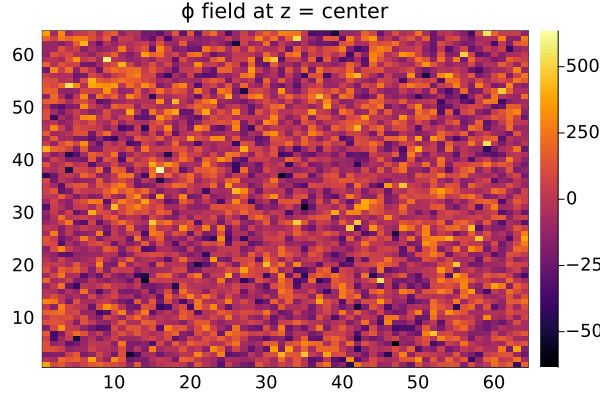

In [288]:
# 初期条件の可視化（中央断面の 2D ヒートマップ）
Plots.heatmap(field[1,:, :, div(Nl,2)], title="ϕ field at z = center", legend=true)

In [11]:
Nspan = (0,Nf)
prob = ODEProblem(EoM!, field, Nspan, (dx));

@time sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=0.1);

 56.285689 seconds (1.96 G allocations: 96.042 GiB, 24.69% gc time, 4.92% compilation time)


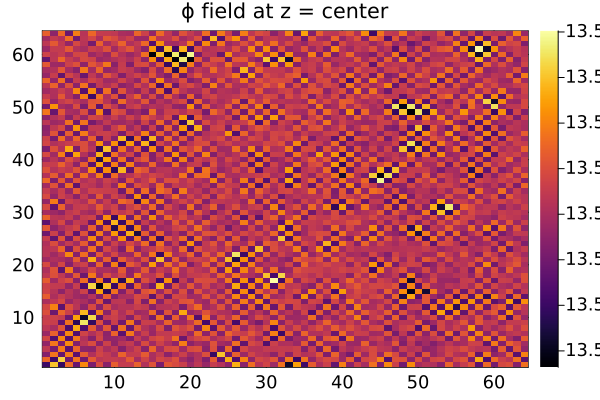

In [13]:
Plots.heatmap(sol.u[end][1, :, :, div(Nl,2)]
    #fieldList[end,1,:,:,div(Nl,2)]
    , title="ϕ field at z = center", legend=true)

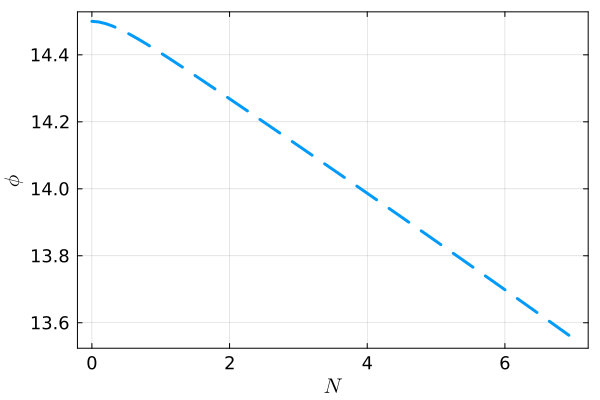

In [15]:
plot(sol.t, [sol.u[i][1,1,1,1] for i in 1:size(sol.u)[1]], xlabel=L"$N$", ylabel=L"$\phi$")